<a href="https://colab.research.google.com/github/vin136/Machine-Learning-Interview-Questions/blob/main/nbs/Causal_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learing for causal inference, some thoughts

**Prediction != Inference**

Given an RCT data can i build two seperate models for avg.treatment effect, μ(T=1,x), μ(T=0,x) and get τ for each observation as `μ(T=1,$x_i$)-μ(T=0,$x_i$)` ?

Ans:

Typically No. ML optimizes for making the best prediction using the simplest model(less variables). If we have confounders(variables that are correlated with the treatment), it typically drops one of them as we penalize for overfitting (say possibly ignore the treatment). This can gives biased estimates.


**Recommended Papers**:

1. [Recursive partitioning for heterogenous causal effects](https://www.pnas.org/doi/full/10.1073/pnas.1510489113)

2. [Choice as alternative](https://github.com/vin136/Machine-Learning-Interview-Questions/blob/main/choice%20as%20alternative.pdf): Also has my notes on getting the estimator of ATE with all the relevant assumptions needed.

## Tools

**Propensity Scores**

Gotchas

- Typically used only when the treatments are discrete.

Story line

- $e(x) = P(T=1 | x)$, conditioning on whole $x$ might effect our positivity assumption thus a good idea to reduce it to 1 dimension and condition it on that a.k.a propensity score.

- We reweight the data and our new estimator is $$τ = E[Y_{T=1}\frac{1}{e(x)}] - E[Y_{T=0}\frac{1}{1- e(x)}]$$

- Model $e(x)$ using ML.

Caution 
- You must ensure that your ML model outputs a calibrated probability prediction. Often times it's better to use a simple model like logistic regression than a complicated ML model as here reducing prediction error is not the objective

- if the
propensity scores are very close to 0 or 1, the estimates will blow up. In
order to prevent this, it is not uncommon to trim the propensity scores.

- Selection Bias: A/B testing or complete randomness is a highbar. When you send a survey(randomly), natually some customers don’t respond and we should take this into account in our analysis. If the non-respondents are mostly unsatisfied customers, the result you’ll get back from the survey will be an artificially inflated rate. You can account for this by estimating response probability and doing similar to IPW. We can combine both and account for both **selection bias and confounding**.

Intuition

- You are giving high importance to the treated that look like the untreated and vice-versa. Makes sense.

**Think on these**

Is it true that Better estimate of the treatment assignment mechanism => better causal estimates. Why or Why not ?

Ans:

I can see via positivity vs conditional unconfoundedness tradeoff how by potentially adding more covariates and getting better estimates might be a bad idea for inference. But since i got labels here, i can still resolve this by cross-validation. Is that it ? other way to see it is how we use these estimates to ultimately get our ATE and if these values are concentrated near 0 or 1, then Variance of ATE increases.





In [ ]:
np.random.seed(42)
school_a = pd.DataFrame(dict(T=np.random.binomial(1, .99, 400), school=0, intercept=1))
school_b = pd.DataFrame(dict(T=np.random.binomial(1, .01, 400), school=1, intercept=1))
ex_data = pd.concat([school_a, school_b]).assign(y = lambda d: np.random.normal(1 + 0.1 * d["T"]))
ex_data.head()

,T,school,intercept,y
0,1,0,1,0.309526
1,1,0,1,1.571468
2,1,0,1,2.982024
3,1,0,1,2.445420
4,1,0,1,2.693187


In [ ]:
from joblib import Parallel, delayed # for parallel processing
from sklearn.linear_model import LogisticRegression

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

In [ ]:
ate_w_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["school"], "T", "y") for _ in range(500)])
ate_wo_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["intercept"], "T", "y") for _ in range(500)])

In [ ]:
np.mean(ate_w_f),np.mean(ate_wo_f)
#strange.

(-0.46647222372338654, 0.090734900162471)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


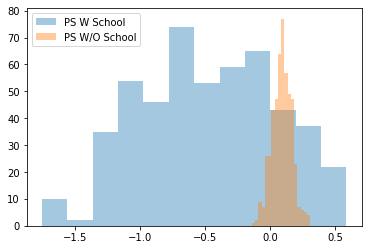

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(ate_w_f, kde=False, label="PS W School")
sns.distplot(ate_wo_f, kde=False, label="PS W/O School")
plt.legend();

In [ ]:
"""
Estimating the causal effect of sodium on blood pressure in a simulated example
adapted from Luque-Fernandez et al. (2018):
    https://academic.oup.com/ije/article/48/2/640/5248195
"""

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


def generate_data(n=1000, seed=1, beta1=1.05, alpha1=0.4, alpha2=0.3, binary_treatment=True, binary_cutoff=3.5):
    np.random.seed(seed)
    age = np.random.normal(65, 5, n)
    sodium = age / 18 + np.random.normal(size=n)
    if binary_treatment:
        if binary_cutoff is None:
            binary_cutoff = sodium.mean()
        sodium = (sodium > binary_cutoff).astype(int)
    blood_pressure = beta1 * sodium + 2 * age + np.random.normal(size=n)
    proteinuria = alpha1 * sodium + alpha2 * blood_pressure + np.random.normal(size=n)
    hypertension = (blood_pressure >= 140).astype(int)  # not used, but could be used for binary outcomes
    return pd.DataFrame({'blood_pressure': blood_pressure, 'sodium': sodium,
                         'age': age, 'proteinuria': proteinuria})




In [ ]:
def estimate_causal_effect(Xt, y, model=LinearRegression(), treatment_idx=0, regression_coef=False):
    model.fit(Xt, y)
    if regression_coef:
        return model.coef_[treatment_idx]
    else:
        Xt1 = pd.DataFrame.copy(Xt)
        Xt1[Xt.columns[treatment_idx]] = 1
        Xt0 = pd.DataFrame.copy(Xt)
        Xt0[Xt.columns[treatment_idx]] = 0
        return (model.predict(Xt1) - model.predict(Xt0)).mean()




In [ ]:



repeat_cnt = 1000
# Adjustment formula estimates
ate_est_naive = []
ate_est_adjust_all = []
ate_est_adjust_age = []

for i in range(repeat_cnt):
  # change random seed
  df = generate_data(beta1=1.05, alpha1=.4, alpha2=.3, binary_treatment=True, n=1000,seed = i)
  
  ate_est_naive.append(estimate_causal_effect(df[['sodium']], df['blood_pressure'], treatment_idx=0))
  ate_est_adjust_all.append(estimate_causal_effect(df[['sodium', 'age', 'proteinuria']],
                                              df['blood_pressure'], treatment_idx=0))
  ate_est_adjust_age.append(estimate_causal_effect(df[['sodium', 'age']], df['blood_pressure']))
print('# Adjustment Formula Estimates #')
print('Naive ATE estimate:\t\t\t\t\t\t\t', np.mean(ate_est_naive))
print('ATE estimate adjusting for all covariates:\t', np.mean(ate_est_adjust_all))
print('ATE estimate adjusting for age:\t\t\t\t', np.mean(ate_est_adjust_age))
print()

    

# Adjustment Formula Estimates #
Naive ATE estimate:							 5.330021342829084
ATE estimate adjusting for all covariates:	 0.8551880095411735
ATE estimate adjusting for age:				 1.0507577659728093



## Instrumental Variables

In [ ]:
!pip install linearmodels

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.iv import IV2SLS

%matplotlib inline

pd.set_option("display.max_columns", 5)
style.use("fivethirtyeight")

Why ?

For estimating causal effect we sometimes(often) can't observe all the variables. Can we estimate causal effect in those situations ?

We can if we have `Z` st. cov(z,t) != 0(can verify) and Y independent of Z given T(can't verify)

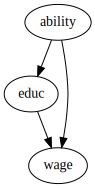

In [4]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g

In [5]:
# effect of strength of correlation

np.random.seed(12)
n = 10000
X = np.random.normal(0, 2, n) # observable variable
U = np.random.normal(0, 2, n) # unobservable (omitted) variable
T = np.random.normal(1 + 0.5*U, 5, n) # treatment
Y = np.random.normal(2 + X - 0.5*U + 2*T, 5, n) # outcome

stddevs = np.linspace(0.1, 100, 50)
Zs = {f"Z_{z}": np.random.normal(T, s, n) for z, s in enumerate(stddevs)} # instruments with decreasing \mathrm{Cov}(Z, T)

sim_data = pd.DataFrame(dict(U=U, T=T, Y=Y)).assign(**Zs)

sim_data.head()

,U,T,...,Z_48,Z_49
0,2.696148,8.056988,...,-117.798705,-13.485292
1,2.570240,0.245067,...,-209.727577,-70.792948
2,0.664741,5.597510,...,60.562232,47.619414
3,1.037725,0.493532,...,78.136513,-108.322304
4,-2.590591,-6.263014,...,78.776566,-80.547214


In [6]:
corr = (sim_data.corr()["T"]
        [lambda d: d.index.str.startswith("Z")])

corr.head()

Z_0    0.999807
Z_1    0.919713
Z_2    0.773434
Z_3    0.634614
Z_4    0.523719
Name: T, dtype: float64

In [7]:
se = []
ate = []
for z in range(len(Zs)):
    formula = f'Y ~ 1 + X + [T ~ Z_{z}]'
    iv = IV2SLS.from_formula(formula, sim_data).fit()
    se.append(iv.std_errors["T"])
    ate.append(iv.params["T"])

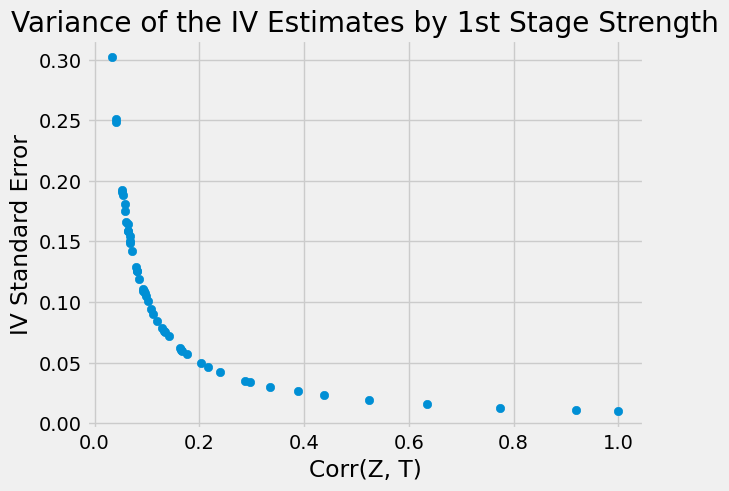

In [8]:
plot_data = pd.DataFrame(dict(se=se, ate=ate, corr=corr)).sort_values(by="corr")

plt.scatter(plot_data["corr"], plot_data["se"])
plt.xlabel("Corr(Z, T)")
plt.ylabel("IV Standard Error");
plt.title("Variance of the IV Estimates by 1st Stage Strength");

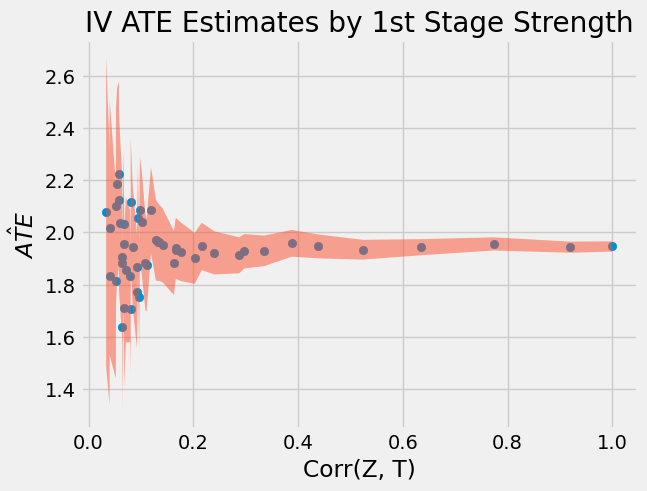

In [9]:
plt.scatter(plot_data["corr"], plot_data["ate"])
plt.fill_between(plot_data["corr"],
                 plot_data["ate"]+1.96*plot_data["se"],
                 plot_data["ate"]-1.96*plot_data["se"], alpha=.5)
plt.xlabel("Corr(Z, T)")
plt.ylabel("$\hat{ATE}$");
plt.title("IV ATE Estimates by 1st Stage Strength");